#####
##### **SAGEMAKER - MULTI-VARIANT DEPLOYMENT & EVALUATION**

In [31]:
import pandas as pd
import numpy as np
import sagemaker
import datetime
import botocore
import tarfile
import pprint
import pickle
import boto3
import json
import time
import re
import os

import tensorflow as tf

from sagemaker.predictor import Predictor
from sagemaker.tensorflow.model import TensorFlowModel
from sagemaker.serializers import CSVSerializer,JSONSerializer,JSONLinesSerializer
from sagemaker.deserializers import JSONDeserializer,JSONLinesDeserializer
from sagemaker.session import production_variant
from sagemaker.model_monitor import DataCaptureConfig

config = botocore.config.Config()
s3_resource = boto3.resource('s3')
sm_client = boto3.client(service_name = 'sagemaker', config = config)
sm_runtime = boto3.client('sagemaker-runtime', config = config)
sess = sagemaker.Session(sagemaker_client = sm_client, sagemaker_runtime_client = sm_runtime)
cw = boto3.client(service_name='cloudwatch', config=config)

In [6]:
model_db = pd.DataFrame(sm_client.list_models()['Models'])

In [7]:
model_db

,ModelName,ModelArn,CreationTime
0,model-4,arn:aws:sagemaker:us-west-2:668209712187:model...,2023-02-16 13:03:29.979000+01:00
1,model-3,arn:aws:sagemaker:us-west-2:668209712187:model...,2023-02-16 13:03:26.750000+01:00
2,model-2,arn:aws:sagemaker:us-west-2:668209712187:model...,2023-02-16 13:03:23.461000+01:00
3,model-1,arn:aws:sagemaker:us-west-2:668209712187:model...,2023-02-16 13:02:56.660000+01:00
4,model-0,arn:aws:sagemaker:us-west-2:668209712187:model...,2023-02-16 13:02:49.626000+01:00


In [8]:
# check models have their associated data; prune those that don't

def check_model_health(delete=False, verbose=True):
    for model in sm_client.list_models()['Models']:
        model_description = sm_client.describe_model(ModelName=model['ModelName'])
        s3_url = model_description['PrimaryContainer']['ModelDataUrl']
        bucket = re.split('/+', s3_url)[1]
        path = re.split('s3://'+bucket+'/', s3_url)[1]
        try:
            s3_resource.Object(bucket, path).load()
            if verbose is True: print('Model', model['ModelName'], 'has its data attached')
        except:
            if verbose is True: print('Model', model['ModelName'], 'has a data issue', end='')
            if delete is True:
                print('...deleting...')
                sm_client.delete_model(ModelName=model['ModelName'])

In [9]:
check_model_health()

Model model-4 has its data attached
Model model-3 has its data attached
Model model-2 has its data attached
Model model-1 has its data attached
Model model-0 has its data attached


In [10]:
active_models = list(model_db['ModelName'])
active_models

['model-4', 'model-3', 'model-2', 'model-1', 'model-0']

#####
##### **INITIAL DEPLOYMENT WITH MODEL VARIANTS AND DATA CAPTURE**

In [37]:
def create_endpoint_config(endpoint_config_name, prod_variants):
    for endpoint_config in sm_client.list_endpoint_configs()['EndpointConfigs']:
        if endpoint_config_name == endpoint_config['EndpointConfigName']:
            print('Endpoint configuration {} already exists'.format(endpoint_config_name))
            return
    
    s3_capture_upload_path = 's3://hwm-nba/data_capture'
    data_capture_config = DataCaptureConfig(
                        enable_capture=True,
                        sampling_percentage=100,
                        destination_s3_uri=s3_capture_upload_path)
        
    endpoint_config = sm_client.create_endpoint_config(
        EndpointConfigName=endpoint_config_name, 
        ProductionVariants=prod_variants,
        DataCaptureConfig=data_capture_config._to_request_dict()
    )
    pprint.PrettyPrinter(indent=4).pprint(endpoint_config)
    time.sleep(5) # to ensure its finished before we create the endpoint itself

 
def create_endpoint(endpoint_name, endpoint_config_name):
    for endpoint in sm_client.list_endpoints()['Endpoints']:
        if endpoint_name == endpoint['EndpointName']:
            print('Endpoint {} already exists'.format(endpoint_name))
            return
    endpoint = sm_client.create_endpoint(
        EndpointName=endpoint_name,
        EndpointConfigName=endpoint_config_name
    )
    waiter = sm_client.get_waiter('endpoint_in_service')
    waiter.wait(EndpointName=endpoint_name)
    pprint.PrettyPrinter(indent=4).pprint(endpoint)


# absorb the above functions into this
def deploy_model_variants(models, name=None, config=None, instance_type='ml.c5.large'): # models
    traffic_splits = [int(100/len(models)) for a in range(len(models)-1)]
    traffic_splits.append(100-sum(traffic_splits))
    traffic_splits
    
    prod_variants = []
    instance_type = instance_type

    for i, m in enumerate(models):
        prod_variants.append(
            production_variant(
                model_name=m, # Replace None
                instance_type=instance_type, # Replace None
                initial_weight=traffic_splits[i],
                initial_instance_count=1,
                variant_name='Variant-'+str(i+1)
            ))
        #print(prod_variants[-1])
        
    timestamp = str(int(time.time()))
    if config is None:
        endpoint_config_name = 'production-endpoint-config-' + timestamp
    if name is None:
        endpoint_name = 'production-endpoint-' + timestamp
        
    create_endpoint_config(endpoint_config_name, prod_variants)
    time.sleep(5) # check if we need this
    create_endpoint(endpoint_name, endpoint_config_name)
    
    configs = {
        'endpoint_config_name': endpoint_config_name,
        'endpoint_name': endpoint_name,
        'variants': {}
    }
    for i,m in enumerate(models):
        configs['variants']['Variant-'+str(i+1)] = traffic_splits[i]
    
    return configs

In [14]:
deployment_configs = deploy_model_variants(active_models)

{   'EndpointConfigArn': 'arn:aws:sagemaker:us-west-2:668209712187:endpoint-config/production-endpoint-config-1676582885',
    'ResponseMetadata': {   'HTTPHeaders': {   'content-length': '118',
                                               'content-type': 'application/x-amz-json-1.1',
                                               'date': 'Thu, 16 Feb 2023 '
                                                       '21:28:05 GMT',
                                               'x-amzn-requestid': '87aa21c6-d33f-4dd3-856d-66a47ac7ca0a'},
                            'HTTPStatusCode': 200,
                            'RequestId': '87aa21c6-d33f-4dd3-856d-66a47ac7ca0a',
                            'RetryAttempts': 0}}
{   'EndpointArn': 'arn:aws:sagemaker:us-west-2:668209712187:endpoint/production-endpoint-1676582885',
    'ResponseMetadata': {   'HTTPHeaders': {   'content-length': '98',
                                               'content-type': 'application/x-amz-json-1.1',
          

In [15]:
deployment_configs

{'endpoint_config_name': 'production-endpoint-config-1676582885',
 'endpoint_name': 'production-endpoint-1676582885',
 'variants': {'Variant-1': 20,
  'Variant-2': 20,
  'Variant-3': 20,
  'Variant-4': 20,
  'Variant-5': 20}}

#####
##### **PREDICT AND UPDATE LIVE VARIANTS**

In [16]:
class CSVPredictor(Predictor):
    def __init__(self, endpoint_name, sess):
        super().__init__(endpoint_name,
                         sagemaker_session=sess,
                         serializer=CSVSerializer(),
                         deserializer=JSONDeserializer())

In [17]:
# here we fetch new data - replace with S3 hookup
with open('../data/processed/games_split.pickle', 'rb') as f:
    ((x_train, x_val, x_test),(y_train, y_val, y_test)) = pickle.load(f)
# new_data = x_train[:10], y_train[:10]

In [18]:
def run_prediction(data, endpoint_name, variant_name=None):
    x_test, y_test = data
    predictor = CSVPredictor(endpoint_name, sess)
    test_data = np.array(x_test)
    # test_data = np.concatenate([np.asarray([x_test.columns]), x_test], axis=0) # dummy first row
    test_data = np.concatenate([np.zeros(x_test.shape[1])[np.newaxis], x_test], axis=0)
    ind = np.asarray([[n] for n in np.arange(len(x_test))])
    test_data = np.concatenate([x_test, ind], axis=1)
    predicted_classes = predictor.predict(x_test, target_variant=variant_name) # if variant is none, our weights are used, but we can force if needed
    predicted_classes = np.array(predicted_classes['predictions']).squeeze()   
    if predicted_classes.shape == (): predicted_classes = predicted_classes[np.newaxis]
    preds = np.asarray([np.int(round(p)) for p in predicted_classes])

    real = np.asarray(y_test)
    accuracy= np.mean(preds==real) # print('Accuracy is:', accuracy)
    return {'variant': variant_name, 'trials': len(preds), 'successes': np.sum(preds==real),
            'fails': np.sum(preds!=real), 'reward': max(0,(2*np.mean(preds==real))-1), 'timestamp': str(int(time.time()))}

In [19]:
# variant selection from inference data, using MAB or Thompson Sampling approach

def variant_selector_v1(data, method='thompson', epsilon=0.1, start=1.1, rounds=500, mean_rewards=None):
    (x,y) = data
    if mean_rewards is None:
        mean_rewards = {}
        for i in range(len(arms)):
            mean_rewards[i] = {'invocations': 0, 'successes': 0, 'fails': 0, 'reward': start}
    for r in range(rounds):
        
        if method == 'thompson':
            beta_samples = [np.random.beta(max(1,mean_rewards[k]['successes']), max(1,mean_rewards[k]['fails']), 1)[0] for k in mean_rewards.keys()]
            i = np.argmax(beta_samples)
            # print(i)
        elif r == 0:
            i = np.random.randint(len(arms))
        elif epsilon >= np.random.random():
            i = np.random.randint(len(arms))
        else:
            qs = [mean_rewards[j]['reward'] for j in mean_rewards.keys()]
            max_q = np.max(qs)
            i_s = [k for k in mean_rewards.keys() if mean_rewards[k]['reward'] == max_q]
            i = i_s[np.random.randint(len(i_s))]
        
        
        subset = np.random.choice(x.shape[0], 1, replace=False) #int(len(x)*0.1)
        x_s = x[subset, :]
        y_s = y[subset]
        preds = np.round(arms[i]['model'].predict(x_s, verbose=0)).squeeze()
        
        
        if type(preds) != np.array: preds = preds[np.newaxis]
        q = np.mean(preds == y_s)
        successes = np.sum(preds == y_s)
        fails = np.sum(preds != y_s)
        if i not in mean_rewards.keys():
            mean_rewards[i] = {'invocations': len(preds), 'successes': successes, 'fails': fails, 'reward': q}
        else:
            mean_rewards[i]['reward'] *= mean_rewards[i]['invocations']
            mean_rewards[i]['reward'] += q
            mean_rewards[i]['successes'] += successes
            mean_rewards[i]['fails'] += fails
            mean_rewards[i]['invocations'] += len(preds)
            mean_rewards[i]['reward'] /= mean_rewards[i]['invocations']
    return mean_rewards
    

In [22]:
def variant_selector_v2(arms, method='thompson', rounds=1000):
    variant_weights = {}
    variant_simulations = []
    for r in range(rounds):
        if method == 'thompson':
            beta_samples = [np.random.beta(max(1,a['successes']), max(1,a['fails']), 1)[0] for a in arms]
            v = np.argmax(beta_samples)
        elif r == 0:
            v = np.random.randint(len(arms))
        elif epsilon >= np.random.random():
            v = np.random.randint(len(arms))
        else:
            max_q = np.max([a['reward'] for a in arms])
            variants = [a for a in arms if a['reward'] == max_q]
            v = variants[np.random.randint(len(variants))]
        variant_simulations.append(v)
    
    weight_sum = 0
    for i in range(len(arms)):
        if i==len(arms):
            variant_weights[arms[i]['variant']] = np.round(1 - weight_sum, 3)
        else:
            variant_weights[arms[i]['variant']] = np.round(np.mean(np.array(variant_simulations)==i), 3)
            weight_sum += variant_weights[arms[i]['variant']]
    
    return variant_weights

In [21]:
run_prediction((x_train[:500], y_train[:500]), deployment_configs['endpoint_name'], variant_name='Variant-4')

{'variant': 'Variant-4',
 'trials': 500,
 'successes': 355,
 'fails': 145,
 'reward': 0.41999999999999993,
 'timestamp': '1676583181'}

In [470]:
def predict_and_update(endpoint_name, variant_name=None, batches=50):
    # fetch new data (S3) - this we can plumb in later
    new_x, new_y = x_train[:500], y_train[:500]
    variants = [k for k in deployment_configs['variants'].keys()]
    
    pred_history = []
    for v in variants:
        results = run_prediction((new_x, new_y), deployment_configs['endpoint_name'], variant_name=v)
        pred_history.append(results)
        
    pred_history_df = pd.DataFrame.from_dict(pred_history)

    history_path = os.path.join('/'.join(os.getcwd().split('/')[:-1]), 'models/_model_data/pred_history.csv')
    try:
        pred_history_existing = pd.read_csv(history_path)
        pred_history_df = pd.concat([pred_history_existing, pred_history_df], axis=0)
    except:
        pass
    
    pred_history_df.to_csv(history_path, index=False)
    new_endpoint_weights = variant_selector_v2(pred_history) # function above
    updated_endpoint_config = []
    
    
    for v in variants:
        updated_endpoint_config.append({'VariantName': v, 'DesiredWeight': new_endpoint_weights[v]})
    
    sm_client.update_endpoint_weights_and_capacities(
        EndpointName=endpoint_name,
        DesiredWeightsAndCapacities=updated_endpoint_config
    )

    waiter = sm_client.get_waiter('endpoint_in_service')
    waiter.wait(EndpointName=endpoint_name)
    
    print('Finished Baby!')
    return updated_endpoint_config

In [471]:
predict_and_update(deployment_configs['endpoint_name'])

Finished Baby!


[{'VariantName': 'Variant-1', 'DesiredWeight': 0.0},
 {'VariantName': 'Variant-2', 'DesiredWeight': 0.191},
 {'VariantName': 'Variant-3', 'DesiredWeight': 0.301},
 {'VariantName': 'Variant-4', 'DesiredWeight': 0.324},
 {'VariantName': 'Variant-5', 'DesiredWeight': 0.184}]

In [ ]:
## make a clean up function

#####
##### **DATA CAPTURE TESTS**

In [26]:
def read_s3(file_path, bucket='hwm-nba', output=None, columns=None):
    data = s3_resource.Object(bucket, file_path).get()['Body'].read()
    if file_path[-3:] == 'zip':
        data = zipfile.ZipFile(BytesIO(data))
        data = data.read(data.namelist()[0])
    data = data.decode('utf-8')
    if output == 'dataframe':
        kwargs = {'header': 0}
        if columns is not None: kwargs['names'] = columns
        data = pd.read_csv(StringIO(data), **kwargs)
    return data

In [27]:
my_bucket = s3_resource.Bucket('hwm-nba')

for object_summary in my_bucket.objects.filter(Prefix='data_capture/'):
    mypath = object_summary.key
    break

In [38]:
mypath

'data_capture/production-endpoint-1676582885/Variant-4/2023/02/16/21/33-01-380-e2daee4d-36d7-4cb7-a564-fc4f772f55f5.jsonl'

In [32]:
data_captured = read_s3(mypath, 'hwm-nba')

In [36]:
json.loads(data_captured)

{'captureData': {'endpointInput': {'observedContentType': 'text/csv',
   'mode': 'INPUT',
   'data': '0.8787878787878788,0.9393939393939394,1.0,0.0,0.09090909090909088,0.03703703703703704,0.0,0.0,0.0,0.0,1.0,0.0,0.28,0.325,0.18518518518518517,0.13333333333333336,1.0,1.0,0.8999999999999999,0.75,0.7826086956521738,0.7701149425287356,1.0,1.0,0.7,0.7999999999999999,0.782608695652174,0.8160919540229886,0.15,0.0,0.0,0.5,0.5,0.5714285714285714,0.5384615384615384,0.010204081632653062,0.5,0.5000000000000001,0.25,0.5714285714285714,0.46153846153846156,0.006802721088435375,0.5205479452054794,0.19718309859154928,0.6249999999999999,0.0606060606060606,0.5776848591549296,0.38235294117647056,0.3076923076923077,0.33283132530120485,0.6774193548387097,0.5068493150684932,0.2112676056338028,0.55,0.20588235294117646,0.5002200704225352,0.4411764705882354,0.21052631578947367,0.40035140562249,0.664,1.0,0.5906662476429919\n0.7575757575757576,0.45454545454545453,1.0,0.0,0.2727272727272727,0.4444444444444444,0.0,

#####
##### **METRIC EVALUATION - TO TIDY UP**

In [94]:
def plot_endpoint_metrics_for_variants(endpoint_name, 
                                       namespace_name, 
                                       metric_name, 
                                       variant_names, 
                                       start_time, 
                                       end_time):

    # try:
    joint_variant_metrics = None

    for variant_name in variant_names:
        metrics = cw.get_metric_statistics( # extracts the results in a dictionary format
            Namespace=namespace_name, # the namespace of the metric, e.g. "AWS/SageMaker"
            MetricName=metric_name, # the name of the metric, e.g. "CPUUtilization"
            StartTime=start_time, # the time stamp that determines the first data point to return
            EndTime=end_time, # the time stamp that determines the last data point to return
            Period=10, # the granularity, in seconds, of the returned data points
            Statistics=["Sum"], # the metric statistics
            Dimensions=[ # dimensions, as CloudWatch treats each unique combination of dimensions as a separate metric
                {"Name": "EndpointName", "Value": endpoint_name}, 
                {"Name": "VariantName", "Value": variant_name}
            ],
        )

        if metrics["Datapoints"]: # access the results from the distionary using the key "Datapoints"
            df_metrics = pd.DataFrame(metrics["Datapoints"]) \
                .sort_values("Timestamp") \
                .set_index("Timestamp") \
                .drop("Unit", axis=1) \
                .rename(columns={"Sum": variant_name}) # rename the column with the metric results as a variant_name

            if joint_variant_metrics is None:
                joint_variant_metrics = df_metrics
            else:
                joint_variant_metrics = joint_variant_metrics.join(df_metrics, how="outer")

    joint_variant_metrics.plot(title=metric_name)
    # except:
    #     pass

In [95]:
from datetime import datetime, timedelta

start_time = datetime.now() - timedelta(minutes=130)
end_time = datetime.now() + timedelta(minutes=0)

print('Start Time: {}'.format(start_time))
print('End Time: {}'.format(end_time))

Start Time: 2023-02-14 19:03:50.875661
End Time: 2023-02-14 21:13:50.875715


In [96]:
variant_names = ['Variant-'+str(i+1) for i in range(5)]

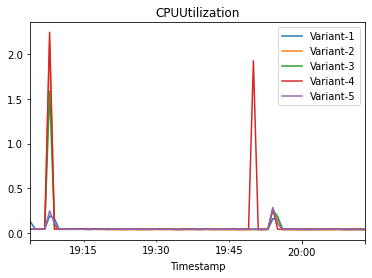

In [97]:
plot_endpoint_metrics_for_variants(
    endpoint_name=endpoint_name, 
    namespace_name='/aws/sagemaker/Endpoints', 
    metric_name='CPUUtilization',
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

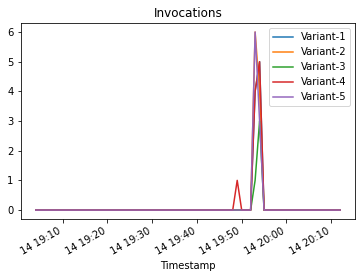

In [98]:
# Invocations
# The number of requests sent to a model endpoint.
plot_endpoint_metrics_for_variants(
    endpoint_name=endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="Invocations",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

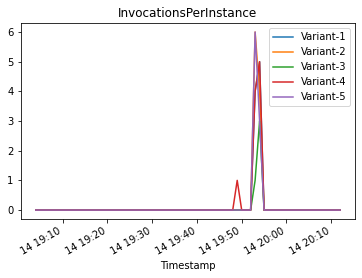

In [99]:
# InvocationsPerInstance
# The number of invocations sent to a model, normalized by InstanceCount in each production variant.
plot_endpoint_metrics_for_variants(
    endpoint_name=endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="InvocationsPerInstance",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

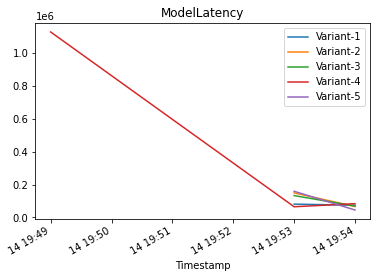

In [100]:
# ModelLatency
# The interval of time taken by a model to respond as viewed from SageMaker (in microseconds).
plot_endpoint_metrics_for_variants(
    endpoint_name=endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="ModelLatency",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)